In [7]:
#!/usr/bin/env python

# make sure to install these packages before running:
# pip install pandas
# pip install sodapy

import pandas as pd
from sodapy import Socrata

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofchicago.org", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.cityofchicago.org,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("v6vf-nfxy", limit=10000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

In [8]:
results_df.head()

,sr_number,sr_type,sr_short_code,owner_department,status,created_date,last_modified_date,closed_date,street_address,city,...,y_coordinate,latitude,longitude,location,:@computed_region_rpca_8um6,:@computed_region_vrxf_vc4k,:@computed_region_6mkv_f3dw,:@computed_region_bdys_3d7i,:@computed_region_43wa_7qmu,parent_sr_number
0,SR20-05038928,Aircraft Noise Complaint,AVN,Aviation,Completed,2020-09-11T11:15:02.000,2020-09-11T11:15:03.000,2020-09-11T11:15:02.000,10510 W ZEMKE RD,Chicago,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SR20-05038927,Aircraft Noise Complaint,AVN,Aviation,Completed,2020-09-11T11:14:54.000,2020-09-11T11:14:55.000,2020-09-11T11:14:55.000,10510 W ZEMKE RD,Chicago,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SR20-05038926,Sewer Cave-In Inspection Request,AAD,DWM - Department of Water Management,Open,2020-09-11T11:14:48.000,2020-09-11T11:14:51.000,NaN,6658 W 52ND ST,NaN,...,1869370.695744,41.79778621,-87.789107341,"{'latitude': '41.797786209593276', 'longitude'...",7,53,22268,588,8,NaN
3,SR20-05038925,Report an Injured Animal,EAQ,Animal Care and Control,Open,2020-09-11T11:14:45.000,2020-09-11T11:14:47.000,NaN,11218 S INDIANA AVE,NaN,...,1830508.64278,41.690203696,-87.618794836,"{'latitude': '41.69020369649667', 'longitude':...",19,45,21861,253,43,NaN
4,SR20-05038924,Building Violation,BBA,DOB - Buildings,Open,2020-09-11T11:14:45.000,2020-09-11T11:14:48.000,NaN,6223 W BYRON ST,NaN,...,1925198.670731,41.950961363,-87.782592998,"{'latitude': '41.95096136278922', 'longitude':...",52,17,22254,443,19,NaN


In [9]:
results_df.shape

(10000, 39)

In [10]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   sr_number                    10000 non-null  object
 1   sr_type                      10000 non-null  object
 2   sr_short_code                10000 non-null  object
 3   owner_department             10000 non-null  object
 4   status                       10000 non-null  object
 5   created_date                 10000 non-null  object
 6   last_modified_date           10000 non-null  object
 7   closed_date                  6704 non-null   object
 8   street_address               9991 non-null   object
 9   city                         4211 non-null   object
 10  state                        4211 non-null   object
 11  zip_code                     9917 non-null   object
 12  street_number                9989 non-null   object
 13  street_direction             998

In [11]:
results_df.status.value_counts()

Completed    6664
Open         3296
Canceled       40
Name: status, dtype: int64

In [15]:
data = pd.DataFrame(results_df[results_df['status']=='Completed'])

In [16]:
data.shape

(6664, 39)

# Basic Model

To get a first model up and running I'm just going to use the the following:
* type of request as a cateogry 
* the day of the week of the request as a category
* department as a category

My target will be whether or not something was completed within the average length of time for that request.

# Target Creation

I need to:
* Find the mean length of time to complete different projects 
* Create a column for the average length of time to completion for each project based on its type
* Assign a yes/no to each request whether it was done under the time for that type of request

In [17]:
# Create a column for length of time (in days) for each request to be completed
import datetime

data['created_date'] = pd.to_datetime(data['created_date'])

data['closed_date'] = pd.to_datetime(data['closed_date'])

In [26]:
data['time_to_close'] = data['closed_date'] - data['created_date']

In [41]:
hours = []

for x in data['time_to_close']:
    hours.append(x.seconds // 3600)

In [42]:
data['hours_to_close'] = hours

In [44]:
data['hours_to_close'].value_counts()

0     6094
1       74
2       46
19      41
3       37
17      34
16      30
20      30
15      28
4       26
18      24
22      23
12      22
21      21
7       20
14      18
13      15
10      14
6       13
11      13
5       12
8       11
23      11
9        7
Name: hours_to_close, dtype: int64

In [45]:
means = data.groupby('sr_type')['hours_to_close'].mean()

In [46]:
means

sr_type
311 INFORMATION ONLY CALL                   0.000000
Abandoned Vehicle Complaint                 7.864865
Aircraft Noise Complaint                    0.000000
Alley Pothole Complaint                     3.000000
Animal In Trap Complaint                    0.000000
Bee/Wasp Removal                           10.000000
Building Violation                          1.666667
Coyote Interaction Complaint               10.000000
Dead Animal Pick-Up Request                12.380000
Dead Bird                                  18.000000
E-Scooter                                   0.000000
Fly Dumping Complaint                      10.555556
Garbage Cart Maintenance                    8.600000
Graffiti Removal Request                    2.843191
Low Water Pressure Complaint                8.500000
Missed Garbage Pick-Up Complaint           12.153846
No Water Complaint                          3.000000
Nuisance Animal Complaint                  12.266667
Open Fire Hydrant Complaint           

In [50]:
# From the mean hours to close per service type, add that information to the dataframe
targets = []

for x in data['sr_type']:
    targets.append(means.loc[x])
    
data['avg_time_by_type'] = targets

In [54]:
# Assign yes/no to each request based on if it was completed in less than mean time
completed = []

for x, y in zip(data['hours_to_close'], data['avg_time_by_type']):
    if x < y:
        completed.append(1)
    else:
        completed.append(0)

In [56]:
data['completed_on_time'] = completed

In [57]:
data.sample(15)

,sr_number,sr_type,sr_short_code,owner_department,status,created_date,last_modified_date,closed_date,street_address,city,...,:@computed_region_rpca_8um6,:@computed_region_vrxf_vc4k,:@computed_region_6mkv_f3dw,:@computed_region_bdys_3d7i,:@computed_region_43wa_7qmu,parent_sr_number,time_to_close,hours_to_close,avg_time_by_type,completed_on_time
5687,SR20-05031396,311 INFORMATION ONLY CALL,311IOC,311 City Services,Completed,2020-09-10 12:13:25,2020-09-10T12:31:35.000,2020-09-10 12:13:25,2111 W Lexington ST,Chicago,...,28,29,21184,5,23,NaN,00:00:00,0,0.000000,0
3632,SR20-05034158,311 INFORMATION ONLY CALL,311IOC,311 City Services,Completed,2020-09-10 15:49:02,2020-09-10T16:30:30.000,2020-09-10 15:49:02,2111 W Lexington ST,Chicago,...,28,29,21184,5,23,NaN,00:00:00,0,0.000000,0
2511,SR20-05035645,311 INFORMATION ONLY CALL,311IOC,311 City Services,Completed,2020-09-10 19:56:07,2020-09-10T20:31:05.000,2020-09-10 19:56:07,2111 W Lexington ST,Chicago,...,28,29,21184,5,23,NaN,00:00:00,0,0.000000,0
8018,SR20-05028064,311 INFORMATION ONLY CALL,311IOC,311 City Services,Completed,2020-09-10 07:17:59,2020-09-10T07:31:35.000,2020-09-10 07:17:59,2111 W Lexington ST,Chicago,...,28,29,21184,5,23,NaN,00:00:00,0,0.000000,0
6447,SR20-05030241,Weed Removal Request,SCP,Streets and Sanitation,Completed,2020-09-10 10:33:08,2020-09-10T10:33:14.000,2020-09-10 10:33:14,3510 W HURON ST,NaN,...,30,24,21572,584,46,NaN,00:00:06,0,0.023364,1
9366,SR20-05026466,Aircraft Noise Complaint,AVN,Aviation,Completed,2020-09-09 18:05:08,2020-09-09T18:30:50.000,2020-09-09 18:05:08,10510 W ZEMKE RD,Chicago,...,38,75,16197,668,29,NaN,00:00:00,0,0.000000,0
6652,SR20-05029971,Weed Removal Request,SCP,Streets and Sanitation,Completed,2020-09-10 10:12:52,2020-09-10T10:13:11.000,2020-09-10 10:13:11,611 N CENTRAL AVE,NaN,...,32,26,22216,673,45,NaN,00:00:19,0,0.023364,1
1430,SR20-05036931,Weed Removal Request,SCP,Streets and Sanitation,Completed,2020-09-11 07:44:58,2020-09-11T07:45:06.000,2020-09-11 07:45:06,5202 S WOLCOTT AVE,NaN,...,37,59,14924,767,2,NaN,00:00:08,0,0.023364,1
1503,SR20-05036840,Aircraft Noise Complaint,AVN,Aviation,Completed,2020-09-11 07:30:15,2020-09-11T08:30:51.000,2020-09-11 07:30:15,10510 W ZEMKE RD,Chicago,...,38,75,16197,668,29,NaN,00:00:00,0,0.000000,0
4277,SR20-05033335,Graffiti Removal Request,GRAF,Streets and Sanitation,Completed,2020-09-10 14:41:27,2020-09-10T14:41:37.000,2020-09-10 14:41:37,4235 S WESTERN AVE,NaN,...,37,55,14924,718,1,NaN,00:00:10,0,2.843191,1


In [58]:
data.shape

(6664, 43)

Target variable is created - 1: completed on time (less than mean for that type of request) or 0: not completed on time.

# Features To Use

For this first model, I just want to get something up and running. Will only use the following features:

* Department
* Community Area

In [93]:
# Set up data using only the above features
data_v1 = data[['owner_department', 'community_area']]

X = pd.get_dummies(data_v1)

In [74]:
X = X.values

In [75]:
y = data['completed_on_time'].values

In [76]:
from sklearn.model_selection import train_test_split

y = y.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 2)

In [77]:
print(X_train.shape)
print(X_test.shape)
print(X.shape)

(4998, 84)
(1666, 84)
(6664, 84)


In [87]:
from sklearn.tree import DecisionTreeClassifier

base_model = DecisionTreeClassifier()

base_model.fit(X_train, y_train)

y_pred = base_model.predict(X_test)

In [88]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.9417767106842737

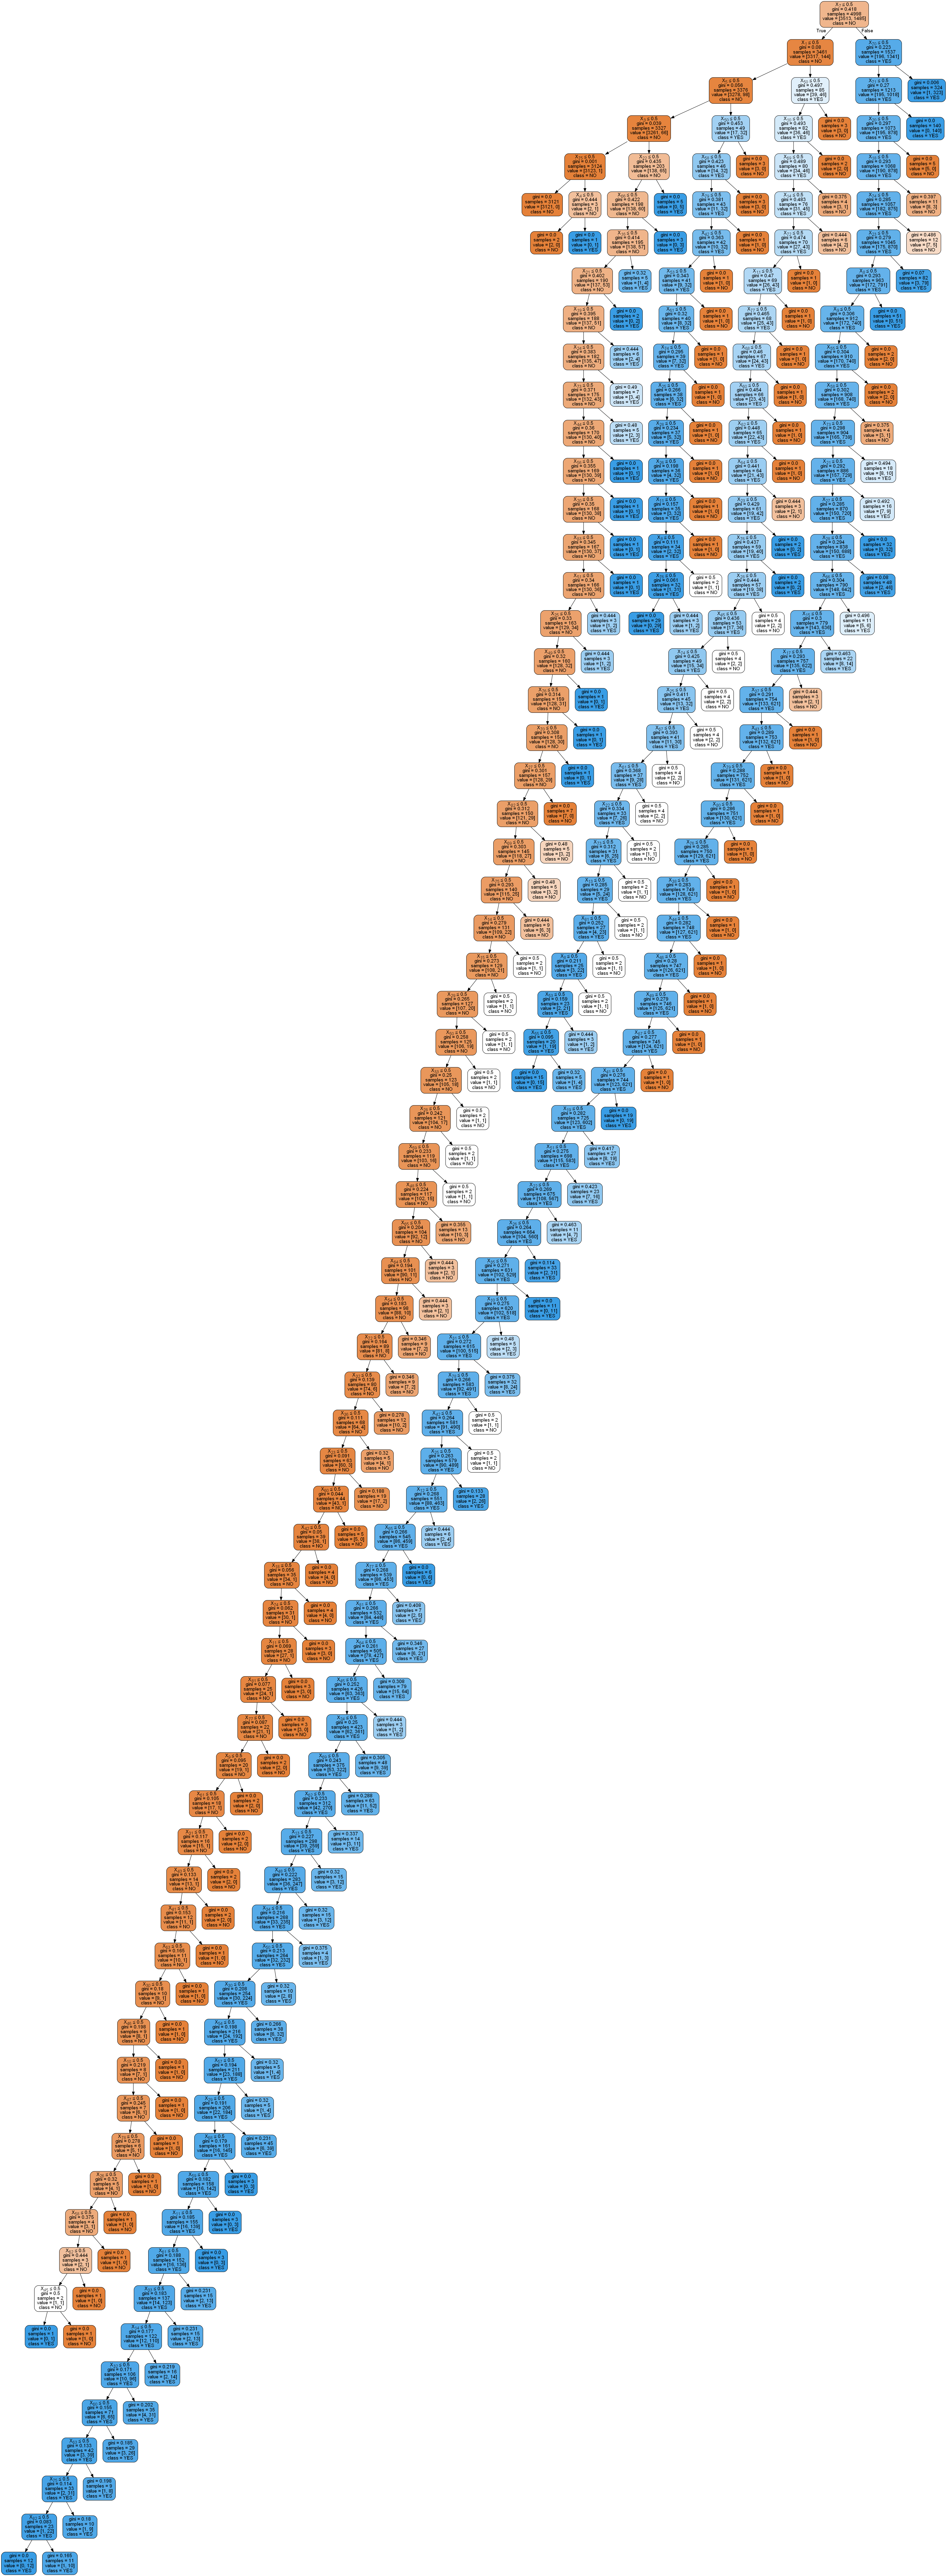

In [95]:
# Now we want to visualize the tree
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz


dot_data = StringIO()

# We can do so with export_graphviz
export_graphviz(base_model, out_file=dot_data,
                    filled=True, rounded=True,
                    special_characters=True, 
                    class_names = ["NO", "YES"])

# Alternatively for class_names use entr_model.classes_
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

That seems way overly complicated. Let's created a much more concise tree.

In [96]:
from sklearn.tree import DecisionTreeClassifier

depth3_model = DecisionTreeClassifier(max_depth=3)

depth3_model.fit(X_train, y_train)

y_pred = depth3_model.predict(X_test)

In [98]:
accuracy_score(y_test, y_pred)

0.93937575030012

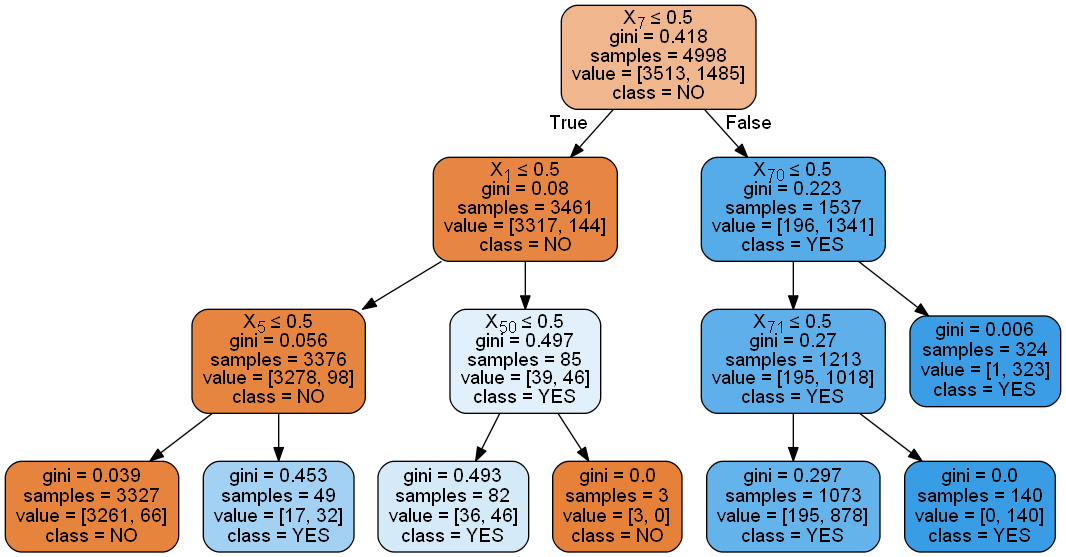

In [100]:
dot_data = StringIO()

# We can do so with export_graphviz
export_graphviz(depth3_model, out_file=dot_data,
                    filled=True, rounded=True,
                    special_characters=True, 
                    class_names = ["NO", "YES"])

# Alternatively for class_names use entr_model.classes_
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())